## Loading files and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/InverseProblem/InverseProblem.zip -d /content/

Archive:  /content/drive/MyDrive/InverseProblem/InverseProblem.zip
   creating: /content/InverseProblem/
   creating: /content/InverseProblem/.git/
  inflating: /content/InverseProblem/.gitignore  
  inflating: /content/InverseProblem/.git/config  
  inflating: /content/InverseProblem/.git/description  
  inflating: /content/InverseProblem/.git/FETCH_HEAD  
 extracting: /content/InverseProblem/.git/HEAD  
   creating: /content/InverseProblem/.git/hooks/
  inflating: /content/InverseProblem/.git/hooks/applypatch-msg.sample  
  inflating: /content/InverseProblem/.git/hooks/commit-msg.sample  
  inflating: /content/InverseProblem/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/InverseProblem/.git/hooks/post-update.sample  
  inflating: /content/InverseProblem/.git/hooks/pre-applypatch.sample  
  inflating: /content/InverseProblem/.git/hooks/pre-commit.sample  
  inflating: /content/InverseProblem/.git/hooks/pre-merge-commit.sample  
  inflating: /content/InverseProblem/.git/h

In [4]:
!unzip /content/drive/MyDrive/InverseProblem/DATA/parameters_base.zip -d /content/InverseProblem/data/

Archive:  /content/drive/MyDrive/InverseProblem/DATA/parameters_base.zip
  inflating: /content/InverseProblem/data/parameters_base.fits  


In [2]:
from astropy.io import fits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sys
sys.path.append('/content/InverseProblem/inverse_problem/normalising_flows/model')
sys.path.append('/content/InverseProblem')
from NFFitter import NFFitter
from inverse_problem.milne_edington.me import read_full_spectra, HinodeME, BatchHinodeME
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params

## Computing training data

In [3]:
DATA_PATH = '/content/InverseProblem/data/parameters_base.fits'

In [4]:
params = fits.open(DATA_PATH)[0].data
lines = None
for i in range(params.shape[0]//100000 + 1):
  print(f'Computing: {100000*i} - {min(100000*(i+1), params.shape[0])}')
  modelBatchME = BatchHinodeME(params[100000*i:min(100000*(i+1), params.shape[0])])
  if lines is None:
    lines = modelBatchME.compute_spectrum()
  else:
    lines = np.concatenate((lines, modelBatchME.compute_spectrum()), axis=0)


lines = np.reshape(lines, (lines.shape[0], lines.shape[1]*lines.shape[2])).astype(np.float32)
params = params.astype(np.float32)
params_scaler = StandardScaler()
sc_params = params_scaler.fit_transform(params)

Computing: 0 - 100000
Computing: 100000 - 200000
Computing: 200000 - 300000
Computing: 300000 - 400000
Computing: 400000 - 500000
Computing: 500000 - 600000
Computing: 600000 - 700000
Computing: 700000 - 800000
Computing: 800000 - 900000
Computing: 900000 - 1000000
Computing: 1000000 - 1100000
Computing: 1100000 - 1200000
Computing: 1200000 - 1300000
Computing: 1300000 - 1400000
Computing: 1400000 - 1500000
Computing: 1500000 - 1600000
Computing: 1600000 - 1700000
Computing: 1700000 - 1800000
Computing: 1800000 - 1900000
Computing: 1900000 - 2000000
Computing: 2000000 - 2100000
Computing: 2100000 - 2200000
Computing: 2200000 - 2300000
Computing: 2300000 - 2400000
Computing: 2400000 - 2500000
Computing: 2500000 - 2600000
Computing: 2600000 - 2700000
Computing: 2700000 - 2800000
Computing: 2800000 - 2900000
Computing: 2900000 - 3000000
Computing: 3000000 - 3100000
Computing: 3100000 - 3200000
Computing: 3200000 - 3237880


## Training

In [7]:
#model = NFFitter(var_size=12, cond_size=lines.shape[1], normalize_y=False, n_layers=11, batch_size=512, n_epochs=1, lr=0.003)
#current_epoch = 0
current_epoch = 140
model = torch.load(f'/content/drive/MyDrive/InverseProblem/saved_models/saved_model_{current_epoch}.pth')

In [18]:
model.lr = 0.01
model.lr

In [20]:
print(f'Start from epoch: {current_epoch}\n=======')
for i in range(10):
  current_epoch += 1
  print(f'Training: {current_epoch - 1} - {current_epoch}')
  model.fit(lines[:-50000], sc_params[:-50000])
  if current_epoch % 5 == 0:
    torch.save(model, f'/content/drive/MyDrive/InverseProblem/saved_models/saved_model_{current_epoch}.pth')

Start from epoch: 140
Training: 140 - 141
Training: 141 - 142
Training: 142 - 143
Training: 143 - 144
Training: 144 - 145
Training: 145 - 146
Training: 146 - 147
Training: 147 - 148
Training: 148 - 149
Training: 149 - 150
Training: 150 - 151
Training: 151 - 152
Training: 152 - 153
Training: 153 - 154
Training: 154 - 155
Training: 155 - 156
Training: 156 - 157
Training: 157 - 158
Training: 158 - 159
Training: 159 - 160


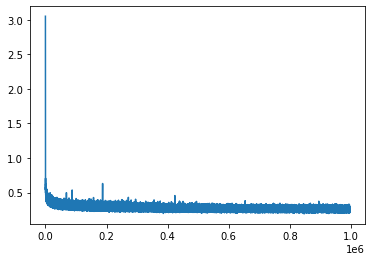

In [22]:
plt.plot(model.loss_history)
plt.show()

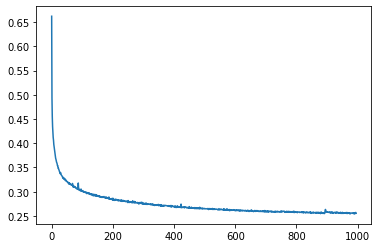

In [28]:
compressed_his = []
for i in range(len(model.loss_history)//1000):
    compressed_his.append(sum(model.loss_history[1000*i:(i+1)*1000])/1000)
plt.plot(compressed_his[:])
plt.show()

In [24]:
names = ['Field_Strength',
             'Field_Inclination',
             'Field_Azimuth',
             'Doppler_Width',
             'Damping',
             'Line_Strength',
             'Original_Continuum_Intensity',
             'Source_Function_Gradient',
             'Doppler_Shift2',
             'Stray_Light_Fill_Factor',
             'Stray_light_Shift']
predicted, _ = model.predict_n_times(lines[-50000:])
unsc_predicted = params_scaler.inverse_transform(predicted[:, :-1])
sc_predicted = predicted[:, :-1]
df_common = compute_metrics(np.expand_dims(sc_params[-50000:,:], axis=0), np.expand_dims(sc_predicted[:,:], axis=0), names, save_path = f'/content/common_pred_{current_epoch}.csv')
df_common

,r2,mse,mae
Field_Strength,0.912,0.028,0.112
Field_Inclination,0.711,0.136,0.217
Field_Azimuth,0.353,0.542,0.512
Doppler_Width,0.924,0.086,0.197
Damping,0.876,0.101,0.208
Line_Strength,0.679,0.387,0.333
Original_Continuum_Intensity,0.555,0.298,0.478
Source_Function_Gradient,0.850,0.269,0.410
Doppler_Shift2,0.843,0.273,0.351
Stray_Light_Fill_Factor,0.551,0.264,0.381


In [25]:
torch.save(model, f'/content/saved_model_{current_epoch}.pth')

In [26]:
torch.save(model, f'/content/drive/MyDrive/InverseProblem/saved_models/saved_model_{current_epoch}.pth')